In [1]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim
import dask
from dask.distributed import Client

# Configure Dask
client = Client(
    n_workers=20,        # or match number of physical cores
    threads_per_worker=2,
    memory_limit="10GB"  # per worker (8 * 10GB = 80GB total)
)
with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            # "shapefile=/beegfs/muduchuru/codes/python/climadata_yield/afg.shp",
            f"time_range.start_date=2020-01-02",
            f"time_range.end_date=2020-01-31",
            "mappings.mswx.params.google_service_account=/home/muduchuru/.climdata_conf/service.json",
            # "+shp_name=afg",
            ]
    )

ds_vars = []
extract_kwargs = {}
# extract_kwargs["shapefile"] = cfg.shapefile
extract_kwargs["box"] = {
    "lat_min":47,
    "lat_max":55,
    "lon_min":5,
    "lon_max":16,
}
# Loop over variables in config
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    mswx = climdata.MSWX(cfg)
    mswx.load(var)
    mswx.extract(**extract_kwargs)
    ds_vars.append(mswx.dataset)

# Merge all variables into one dataset
ds = xr.merge(ds_vars)

# # # Save NetCDF
# region_bounds = cfg.bounds[cfg.region]
# filename = cfg.output.filename_nc.format(
#         provider=cfg.dataset,
#         parameter = "surface",
#         lat_range=f"{region_bounds['lat_min']}-{region_bounds['lat_max']}",
#         lon_range=f"{region_bounds['lon_min']}-{region_bounds['lon_max']}",
#         start=cfg.time_range.start_date.replace("-", ""),
#         end=cfg.time_range.end_date.replace("-", ""),
#     )
# print(f"💾 Saving merged dataset to {filename}")
# for var in ds.data_vars:
#     ds[var] =  xclim.core.units.convert_units_to(
#         ds[var], cfg.mappings["info"][var].units
#     )
# ds.to_netcdf(filename)

📂 Processing variable: tasmin
✅ All 30 tasmin files already exist locally.
📂 Processing variable: tasmax
✅ All 30 tasmax files already exist locally.
📂 Processing variable: pr
✅ All 30 pr files already exist locally.


In [10]:
import hvplot.xarray
import cartopy.crs as ccrs

plot = ds['tasmin'].isel(time=0).hvplot(
    x='lon', y='lat',
    # projection=ccrs.PlateCarree(),
    geo=True,
    coastline=True,
    tiles=True,  # if you like a web‑tile background
    cmap='viridis',
    title='Daily Mean Temperature',
    alpha=0.6,
    width=800,   # width in pixels
    height=600,  # height in pixels
)
plot

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Image.I     :Image   [lon,lat]   (tasmin)
   .Coastline.I :Feature   [Longitude,Latitude]

In [3]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=1989-01-01",
            f"time_range.end_date=2020-12-31",
            "lat=52",
            "lon=14",
            ]
    )
extract_kwargs = {}
# extract_kwargs["shapefile"] = cfg.shapefile
# extract_kwargs["box"] = {
#     "lat_min":47,
#     "lat_max":55,
#     "lon_min":5,
#     "lon_max":16,
# }
extract_kwargs["point"] = (cfg.lon, cfg.lat)
extract_kwargs["buffer_km"] = 30
ds_vars = []
# Loop over variables in config
for var in cfg.variables:
    extract_kwargs["variable"] = var
    dwd = climdata.DWD(cfg)
    ds = dwd.extract(**extract_kwargs)
    ds_vars.append(ds)

ds = xr.merge(ds_vars)

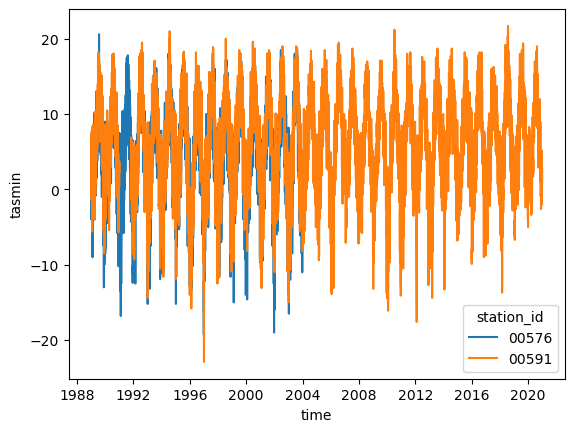

In [10]:
ds = ds.assign_coords(station_id=ds.station_id.astype(str))
ds['tasmin'].plot.line(x='time')

In [19]:
import xarray as xr
import pandas as pd


def check_time_completeness(da: xr.DataArray, freq="D"):
    """
    Check completeness of the time index for each station.
    Reports missing dates and percent completeness.
    """
    results = {}
    full_time = pd.date_range(da.time.min().item(), da.time.max().item(), freq=freq)

    for station in da.station_id.values:
        sub = da.sel(station_id=station)
        missing = full_time.difference(sub.time.to_index())
        completeness = 100 * (1 - len(missing) / len(full_time))

        results[station] = {
            "missing_dates": missing,
            "num_missing": len(missing),
            "percent_complete": completeness,
        }

    return results
def check_nan_values(da: xr.DataArray):
    """
    Count NaN values for each station.
    """
    results = {}
    for station in da.station_id.values:
        sub = da.sel(station_id=station)
        num_nan = sub.isnull().sum().item()
        pct_nan = 100 * num_nan / sub.size

        results[station] = {
            "num_nan": num_nan,
            "pct_nan": pct_nan,
        }

    return results

def check_double_dates(da):
    """
    Detect duplicated timestamps (double dates) for each station.

    Returns a dict with:
      - duplicated timestamps
      - count of duplicates
    """
    results = {}

    for station in da.station_id.values:
        time_index = da.sel(station_id=station).time.to_index()
        duplicates = time_index[time_index.duplicated()].unique()

        results[station] = {
            "duplicates": duplicates,
            "num_duplicates": len(duplicates),
        }

    return results
# check_time_completeness(ds["pr"])

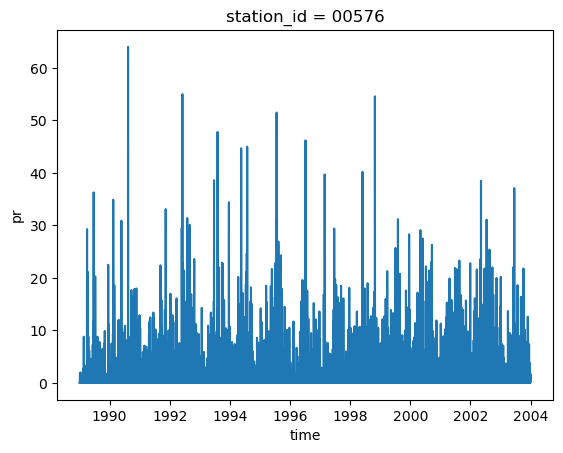

In [ ]:
ds['pr'].sel(station_id="00576").plot()

In [15]:
import xclim
data = ds["value"].isel(station_id=0)
x = xclim.core.cfchecks.cfcheck_from_name("pr", data, attrs=None)
xclim.core.datachecks.check_daily(data)

AttributeError: 'DataArray' object has no attribute 'time'

In [ ]:
import pandas as pd
ds = ds.assign_coords(
    date=ds["date"].to_pandas().tz_localize(None)
)
ds = ds.rename(
    {
        "date": "time",
        "value": "pr",
    }
)
attrs = {}
for attr,n in zip(["resolution", "dataset", "parameter"],["resolution", "dataset", "long_name"]):
    attrs[n] = ds[attr].values[0, 0]

ds = ds.assign_attrs(attrs)
ds = ds.drop_vars(["index", "resolution", "dataset", "parameter"])

In [24]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:     (station_id: 2, time: 11685)
Coordinates:
  * station_id  (station_id) object 16B '00576' '00591'
  * time        (time) datetime64[ns] 93kB 1989-01-01 1989-01-02 ... 2020-12-31
Data variables:
    index       (station_id, time) float64 187kB 0.0 1.0 ... 1.684e+04 1.684e+04
    resolution  (station_id, time) object 187kB 'daily' 'daily' ... 'daily'
    dataset     (station_id, time) object 187kB 'climate_summary' ... 'climat...
    parameter   (station_id, time) object 187kB 'precipitation_height' ... 'p...
    value       (station_id, time) float64 187kB 0.0 0.0 0.0 0.0 ... 0.9 0.0 0.2
    quality     (station_id, time) float64 187kB 10.0 10.0 10.0 ... 9.0 9.0 9.0

In [28]:
import xarray as xr

# Step 1: Apply threshold
mask = ds['pr'] > 50

# Step 2: Stack coordinates into a single dimension (Dask-safe)
exceeding = ds['pr'].where(mask).stack(points=("time", "lat", "lon"))

# Step 3: Drop NaN values
exceeding = exceeding.dropna("points")

# Step 4: Compute only the filtered data
exceeding = exceeding.compute()

# Step 5: Convert to DataFrame (no reset_index!)
exceeding_df = exceeding.to_dataframe(name="pr")['pr'].reset_index()

exceeding_df


,time,lat,lon,pr
0,1989-01-01,42.049999,42.749996,56.0625
1,1989-01-01,42.150002,42.749996,50.8750
2,1989-01-01,42.250000,42.650005,51.1875
3,1989-01-01,42.250000,42.850002,51.4375
4,1989-01-02,66.449997,32.450008,50.5625
...,...,...,...,...
1034434,2020-12-30,42.150002,19.450008,72.4375
1034435,2020-12-30,42.250000,18.749996,58.6250
1034436,2020-12-30,42.349998,19.049999,50.2500
1034437,2020-12-30,42.549999,19.249996,51.2500


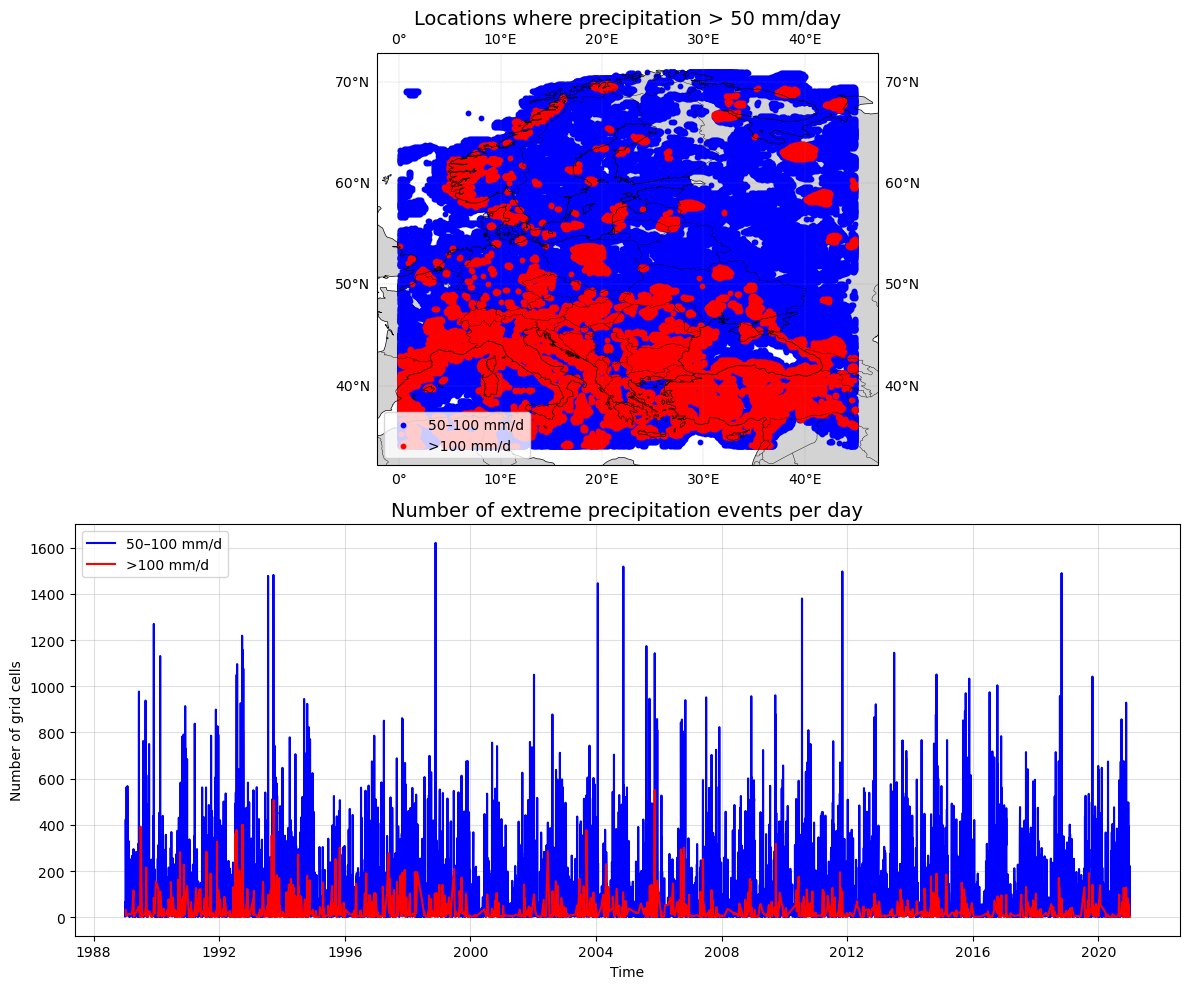

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# --- Separate categories ---
low = exceeding_df[(exceeding_df['pr'] > 50) & (exceeding_df['pr'] <= 100)]
high = exceeding_df[exceeding_df['pr'] > 100]

# --- Count events per day ---
low_counts = low.groupby('time').size()
high_counts = high.groupby('time').size()

# --- Create figure with two panels ---
fig = plt.figure(figsize=(12, 10))

# ============ 1. MAP PLOT ============
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_title("Locations where precipitation > 50 mm/day", fontsize=14)

# Add features
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')

# Scatter points
ax1.scatter(low['lon'], low['lat'], color='blue', s=10, label='50–100 mm/d', transform=ccrs.PlateCarree())
ax1.scatter(high['lon'], high['lat'], color='red', s=10, label='>100 mm/d', transform=ccrs.PlateCarree())

ax1.legend(loc='lower left')
ax1.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')

# ============ 2. TIME SERIES ============
ax2 = plt.subplot(2, 1, 2)
ax2.set_title("Number of extreme precipitation events per day", fontsize=14)

ax2.plot(low_counts.index, low_counts.values, color='blue', label='50–100 mm/d')
ax2.plot(high_counts.index, high_counts.values, color='red', label='>100 mm/d')

ax2.set_ylabel("Number of grid cells")
ax2.set_xlabel("Time")
ax2.legend()
ax2.grid(alpha=0.4)

plt.tight_layout()
plt.show()


In [3]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_cmip", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )

ds_vars = []

# Loop over variables
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    cmip = climdata.CMIP(cfg)
    cmip.fetch()          # get file list
    cmip.load()           # load dataset
    europe_box = cfg.bounds.europe
    cmip.extract(box=europe_box)
    ds_vars.append(cmip.ds)

# Merge all variables
ds_merged = xr.merge(ds_vars)

# Format NetCDF filename
region_bounds = cfg.bounds[cfg.region]
filename = cfg.output.filename_nc.format(
    provider=cfg.dataset,
    parameter="surface",
    lat_range=f"{region_bounds['lat_min']}-{region_bounds['lat_max']}",
    lon_range=f"{region_bounds['lon_min']}-{region_bounds['lon_max']}",
    start=cfg.time_range.start_date.replace("-", ""),
    end=cfg.time_range.end_date.replace("-", "")
)
for var in ds_merged.data_vars:
    ds_merged[var] =  xclim.core.units.convert_units_to(
        ds_merged[var], cfg.mappings["info"][var].units
    )
cmip.ds = ds_merged
cmip.save_netcdf(filename)

📂 Processing variable: tasmax
📂 Processing variable: tasmin
📂 Processing variable: pr
Saved NetCDF to cmip_surface_LAT34.0-71.0_LON-25.0-45.0_20100801_20100831.nc


In [3]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_mswx", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )

ds_vars = []
# Loop over variables in config
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    mswx = climdata.MSWX(cfg)
    ds_var = mswx.load(var)

    # Subset to Europe bounds
    europe_box = cfg.bounds.europe
    ds_var = mswx.extract(point=(52,16))
    ds_vars.append(mswx.dataset)

# Merge all variables into one dataset
ds = xr.merge(ds_vars)

# Save NetCDF
region_bounds = cfg.bounds[cfg.region]
filename = cfg.output.filename_csv.format(
        provider=cfg.dataset,
        parameter = "surface",
        lat=f"{52}",
        lon=f"{16}",
        start=cfg.time_range.start_date.replace("-", ""),
        end=cfg.time_range.end_date.replace("-", ""),
    )
print(f"💾 Saving merged dataset to {filename}")
for var in ds.data_vars:
    ds[var] =  xclim.core.units.convert_units_to(
        ds[var], cfg.mappings["info"][var].units
    )
mswx.dataset = ds
mswx.save_csv(filename)

📂 Processing variable: tasmax
✅ All 31 tasmax files already exist locally.
📂 Processing variable: tasmin
✅ All 31 tasmin files already exist locally.
📂 Processing variable: pr
✅ All 31 pr files already exist locally.
💾 Saving merged dataset to mswx_surface_LAT_52_LON_16_20100801_20100831.csv
Saved CSV to mswx_surface_LAT_52_LON_16_20100801_20100831.csv


In [9]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_cmip", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )

ds_vars = []

# Loop over variables
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    cmip = climdata.CMIP(cfg)
    cmip.fetch()          # get file list
    cmip.load()           # load dataset
    europe_box = cfg.bounds.europe
    cmip.extract(point=(52,16))
    ds_vars.append(cmip.ds)

# Merge all variables
ds_merged = xr.merge(ds_vars)

# Format NetCDF filename
region_bounds = cfg.bounds[cfg.region]
filename = cfg.output.filename_csv.format(
    provider=cfg.dataset,
    parameter="surface",
    lat=f"{52}",
    lon=f"{16}",
    start=cfg.time_range.start_date.replace("-", ""),
    end=cfg.time_range.end_date.replace("-", "")
)
for var in ds_merged.data_vars:
    ds_merged[var] =  xclim.core.units.convert_units_to(
        ds_merged[var], cfg.mappings["info"][var].units
    )
cmip.ds = ds_merged
cmip.save_csv(filename)
# cmip.save_netcdf(filename)

📂 Processing variable: tasmax
📂 Processing variable: tasmin
📂 Processing variable: pr
Saved CSV to cmip_surface_LAT_52_LON_16_20100801_20100831.csv


In [2]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim
import pandas as pd
df_vars = []
with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_dwd", overrides= [
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )
# Loop over variables
for var in cfg.variables:

    print(f"📂 Processing variable: {var}")
    dwd = climdata.DWD(cfg)
    dwd.load(var, 52, 16, buffer_km=100)           # load dataset
    dwd.format(var, 52, 16)
    df_vars.append(dwd.df)

# Merge all variables
df = pd.concat(df_vars,axis=0)

filename = cfg.output.filename_csv.format(
    provider=cfg.dataset,
    parameter="surface",
    lat=f"{52}",
    lon=f"{16}",
    start=cfg.time_range.start_date.replace("-", ""),
    end=cfg.time_range.end_date.replace("-", "")
)
dwd.df = df
dwd.save_csv(filename)
# cmip.save_netcdf(filename)

📂 Processing variable: tasmax
📂 Processing variable: tasmin
📂 Processing variable: pr
✅ Saved time series to: dwd_surface_LAT_52_LON_16_20100801_20100831.csv


'dwd_surface_LAT_52_LON_16_20100801_20100831.csv'

In [4]:
    dwd = climdata.DWD(cfg)
    dwd.load(var, 52, 16, buffer_km=100)           # load dataset

,station_id,resolution,dataset,parameter,date,value,quality
0,06170,daily,climate_summary,precipitation_height,2010-08-01 00:00:00+00:00,0.0,10.0
1,06170,daily,climate_summary,precipitation_height,2010-08-02 00:00:00+00:00,15.8,10.0
2,06170,daily,climate_summary,precipitation_height,2010-08-03 00:00:00+00:00,6.1,10.0
3,06170,daily,climate_summary,precipitation_height,2010-08-04 00:00:00+00:00,0.0,10.0
4,06170,daily,climate_summary,precipitation_height,2010-08-05 00:00:00+00:00,0.0,10.0
5,06170,daily,climate_summary,precipitation_height,2010-08-06 00:00:00+00:00,6.5,10.0
6,06170,daily,climate_summary,precipitation_height,2010-08-07 00:00:00+00:00,3.8,10.0
7,06170,daily,climate_summary,precipitation_height,2010-08-08 00:00:00+00:00,0.0,10.0
8,06170,daily,climate_summary,precipitation_height,2010-08-09 00:00:00+00:00,12.4,10.0
9,06170,daily,climate_summary,precipitation_height,2010-08-10 00:00:00+00:00,0.0,10.0


In [7]:
dwd.df

,station_id,resolution,dataset,parameter,date,value,quality
0,06170,daily,climate_summary,precipitation_height,2010-08-01 00:00:00+00:00,0.0,10.0
1,06170,daily,climate_summary,precipitation_height,2010-08-02 00:00:00+00:00,15.8,10.0
2,06170,daily,climate_summary,precipitation_height,2010-08-03 00:00:00+00:00,6.1,10.0
3,06170,daily,climate_summary,precipitation_height,2010-08-04 00:00:00+00:00,0.0,10.0
4,06170,daily,climate_summary,precipitation_height,2010-08-05 00:00:00+00:00,0.0,10.0
5,06170,daily,climate_summary,precipitation_height,2010-08-06 00:00:00+00:00,6.5,10.0
6,06170,daily,climate_summary,precipitation_height,2010-08-07 00:00:00+00:00,3.8,10.0
7,06170,daily,climate_summary,precipitation_height,2010-08-08 00:00:00+00:00,0.0,10.0
8,06170,daily,climate_summary,precipitation_height,2010-08-09 00:00:00+00:00,12.4,10.0
9,06170,daily,climate_summary,precipitation_height,2010-08-10 00:00:00+00:00,0.0,10.0
